<img align="center" src="http://sydney.edu.au/images/content/about/logo-mono.jpg">
<h1 align="center" style="margin-top:10px">Statistical Learning and Data Mining</h1>
<h2 align="center" style="margin-top:20px">Tutorial 8: Linear Model Selection and Regularisation</h2>
<br>

This tutorial will show how to implement varible selection and regularisation methods for linear regression in Python.

<a href="#1.Ames-Housing-Data">Ames Housing Data</a> <br>
<a href="#2.Exploratory-Data-Analysis">Exploratory Data Analysis</a> <br>
<a href="#3.Feature-Engineering">Feature Engineering</a> <br>
<a href="#4.Subset-Selection">Subset Selection</a> <br>
<a href="#5.Ridge-Regression">Ridge Regression</a> <br>
<a href="#6.Lasso">Lasso</a> <br>
<a href="#7.Elastic-Net">Elastic Net</a> <br>
<a href="#8.Model-Evaluation">Model Evaluation</a> <br> 
<a href="#9.Pipeline-(note)">Pipeline (note)</a> <br> 

In [1]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') 

In [2]:
# Plot settings
sns.set_context('notebook') # optimises figures for notebook display
sns.set_style('ticks') # set default plot style
crayon = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', 
          '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(crayon) # set custom color scheme
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error

### 1. Ames Housing Data

In this tutorial we will continue working with the Ames Housing dataset from [De Cock (2011)](http://www.tandfonline.com/doi/abs/10.1080/10691898.2011.11889627) and the corresponding [Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) practice competition, which we last used on the lesson about feature engineering. 

Our objective is to predict the sale price of the houses (the last column in the dataset). We assume that the loss function is the squared error loss on the log scale. 

We will work with a processed version of the dataset for which we have already taken care of time consuming feature engineering. 

In [4]:
data=pd.read_csv('Data/ames-processed-regression.csv')
data.head()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,...,SaleCondition_Family,SaleCondition_Other,LotFrontageNA,BsmtQualNA,FireplaceQuNA,Condition_Artery,Condition_PosN,Condition_Railroad,Condition_Feedr,SalePrice
0,141.0,10.366278,112.0,0.0,441.0,1080.0,0,0,7.412160,6.270988,...,0,0,0,0,0,0,0,0,0,215000
1,80.0,9.360655,0.0,144.0,270.0,882.0,0,0,6.797940,6.594413,...,0,0,0,0,1,0,0,0,1,105000
2,81.0,9.565704,108.0,0.0,406.0,1329.0,0,0,7.192182,5.746203,...,0,0,0,0,1,0,0,0,0,172000
3,93.0,9.320091,0.0,0.0,1045.0,2110.0,0,0,7.654443,6.259581,...,0,0,0,0,0,0,0,0,0,244000
4,74.0,9.534595,0.0,0.0,137.0,928.0,701,0,7.395722,6.180017,...,0,0,0,0,0,0,0,0,0,189900


In [5]:
variables=pd.read_csv('Data/ames-processed-regression-variables.csv')
variables.head()

,variable,type
0,2ndFlrSF,continuous
1,Age,continuous
2,BsmtFinSF2,continuous
3,BsmtUnfSF,continuous
4,EnclosedPorch,continuous


In [6]:
variables['type'].value_counts()

dummy         172
continuous     22
discrete        9
response        1
Name: type, dtype: int64

As usual, we the split the data into training and test sets. Based on our previous discussion, the respose will be the log of the sale price. 

In [7]:
response='SalePrice'
predictors=list(data.columns.values[:-1])

# Randomly split indexes
index_train, index_test  = train_test_split(np.array(data.index), train_size=0.5, random_state=12)

# Write training and test sets
train = data.loc[index_train,:].copy()
test =  data.loc[index_test,:].copy()

y_train = np.log(train[response].to_numpy())
y_test = np.log(test[response].to_numpy())

### 2. Exploratory Data Analysis

We start by plotting the response as we did in the previous tutorial.

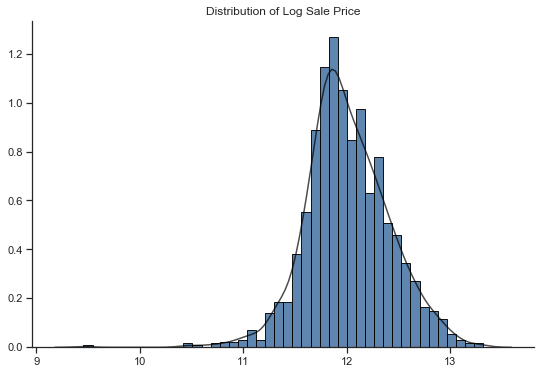

In [8]:
from statlearning import plot_dist
plot_dist(y_train)
plt.title('Distribution of Log Sale Price')
plt.show()

For the next step, it will be helpful to retrieve the list of the predictors that we treat as continuous variables. 

In [9]:
continuous = list(variables.loc[variables['type']=='continuous', 'variable'])
print(continuous)

['2ndFlrSF', 'Age', 'BsmtFinSF2', 'BsmtUnfSF', 'EnclosedPorch', 'GarageAge', 'GarageArea', 'GrLivArea', 'GrLivArea_OverallCond', 'GrLivArea_OverallQual', 'LotArea', 'LotFrontage', 'LowQualFinSF', 'MasVnrArea', 'MiscVal', 'OpenPorchSF', 'PorchArea', 'RemodAge', 'ScreenPorch', 'TotalBsmtSF', 'Trend', 'WoodDeckSF']


The next cell shows you how to visualise the bivariate relationships between the response and the continuous predictors.  These plots are very helpful in guiding our feature engineering (such as transforming predictors and taking care of the variables that have many zeros) and model building.

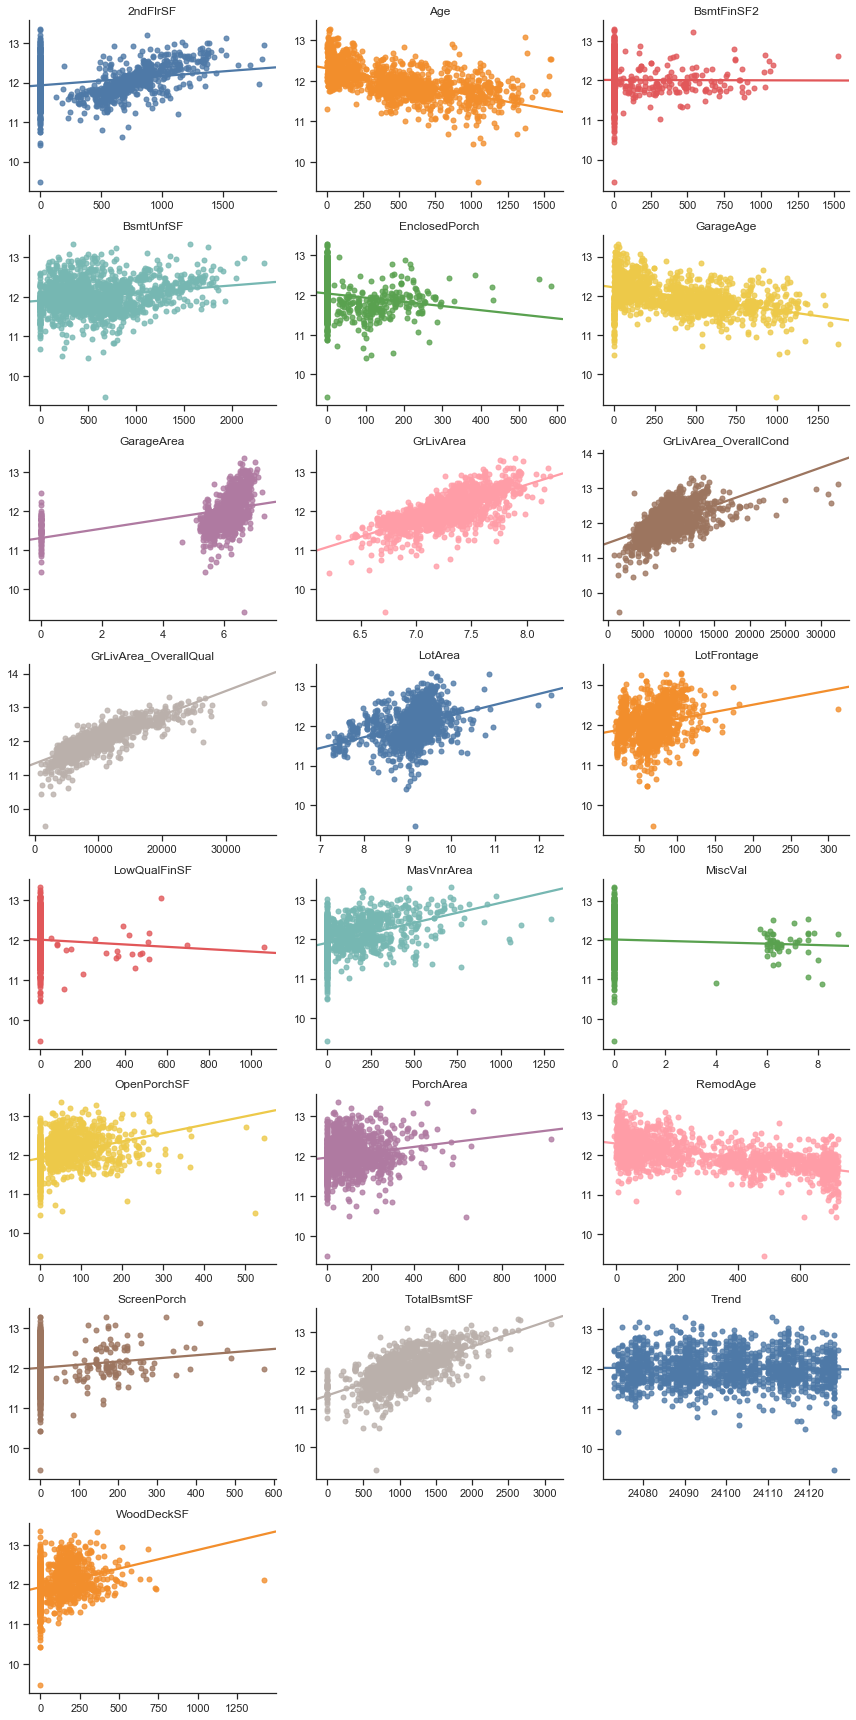

In [10]:
from statlearning import plot_regressions

plot_regressions(train[continuous], y_train)
plt.show()

We can do the same for the discrete variables. 

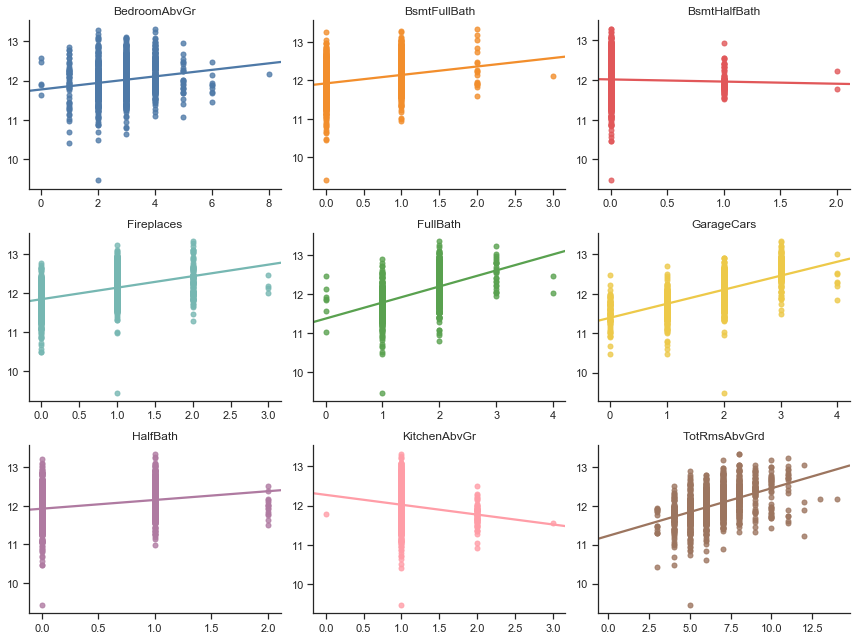

In [11]:
discrete = list(variables.loc[variables['type']=='discrete', 'variable'])
plot_regressions(train[discrete], y_train)
plt.show()

### 3. Feature Engineering

Even though we have already done most of the feature engineering in the background, it is essential to scale the predictors  before fitting regularised linear methods (because the penalty term in the objective function treats all the coefficients as comparable). 

In the lectures we discussed both standardisation and normalisation for scaling. Standardisation is our default method, but normalisation (as defined) turns out to work better for this dataset based on model selection.  The Scikit-Learn [<TT>MinMaxScaler</TT>](https://scikit-learn.org/0.21/modules/generated/sklearn.preprocessing.MinMaxScaler.html) method makes it easy for us to process the predictors in this way.

In [12]:
from sklearn.preprocessing import MinMaxScaler # alternative: StandardScaler

scaler = MinMaxScaler() # alternative: StandardScaler()

X_train = scaler.fit_transform(train[predictors])
X_test = scaler.transform(test[predictors])

The difficulty that we often have is that numerical and binary predictors are not comparable in terms of scale. The ideal would be to (at least try to) use different penalties for the two types of predictors, but this is not a standard implementation. 

In the note at the end of notebook we show how to directly combine scaling with a learning algorithm using a Scikit-Learn [pipeline](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline).

*Note: we use the training data only to fit the scaler. There's often confusion here because of Kaggle competitions. which we also run in the unit. Strictly speaking, a Kaggle competition is semi-supervised learning. Since the goal is to win to competition, you use all the information available in that context, which then includes the predictors values from the test data. In most business scenarios, you don't redo the feature engineering every time a new input comes in.* 

### 4. Subset Selection

Even though Scikit-Learn has functionality for subset selection, its methods are not exactly the same as the methods that we have seen in the lecture. Therefore, we will use the subset selection code written separately in the statistical learning module. In this tutorial we will use forward selection.

Below, we also add a `%%time` cell command to measure how long the it takes to run. Note that due to the many iterations involved in subset selection, fitting these algorithms can take some time to run.

In [13]:
%%time 
# Note: there was a bug with %%time in a recent version of Jupyter, remove it if you get an error 
# in the next cell

from statlearning import forward
fwd = forward()
fwd.fit(X_train, y_train)

Wall time: 1min 35s


The method selects 72 out of 203 predictors. 

In [14]:
len(fwd.subset)

72

### 5. Ridge Regression

The [RidgeCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html) class is the most convenient implementation for ridge regression. The reason for using `RidgeCV`, as opposed to running a grid search on the [<TT>Ridge</TT>](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) class, is that there is an efficient algorithm for computing the path of solutions as we vary the Ridge penalty. The same is the case for the lasso implementation below.

We need to manually specify a grid of the penalty weight values (called alphas by the package). As mentioned in the lecture, we often to do this by generating a grid of values on a logarithmic scale. 

The package uses efficient leave-one-out cross-validation (generalised cross-validation) by default for ridge regression.

In [15]:
from sklearn.linear_model import RidgeCV

alphas = list(np.logspace(-15, 15, 151, base=2))
ridge = RidgeCV(alphas=alphas)
ridge.fit(X_train, y_train)

RidgeCV(alphas=array([3.05176e-05, 3.50555e-05, ..., 2.85262e+04, 3.27680e+04]),
    cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
    scoring=None, store_cv_values=False)

The statlearning module has a function that allows us to faciltate visualisation of the estimated coefficients.

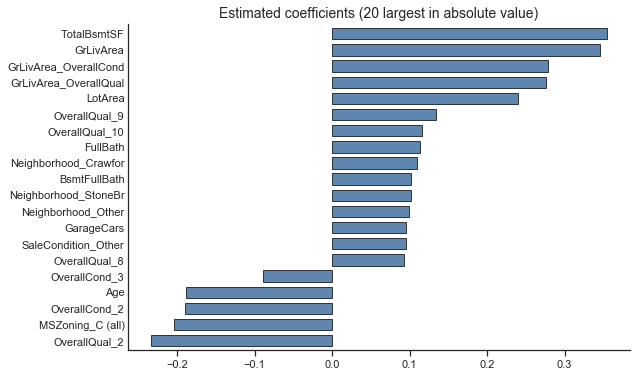

In [16]:
from statlearning import plot_coefficients
plot_coefficients(ridge, predictors)
plt.show()

### 6. Lasso

Similarly to the above, we use the [<TT>LassoCV</TT>](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html) class to fit the lasso model using the in-built algorithm for hyperparameter optimisation.  

In [17]:
from sklearn.linear_model import LassoCV

lasso = LassoCV(cv=5)
lasso.fit(X_train, y_train)

LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

The lasso shrinks 82 coefficients to zero, thus selecting 121 out of 203 predictors–quite a bit more than forward selection.

In [18]:
len(predictors)-np.sum(lasso.coef_==0.0)

121

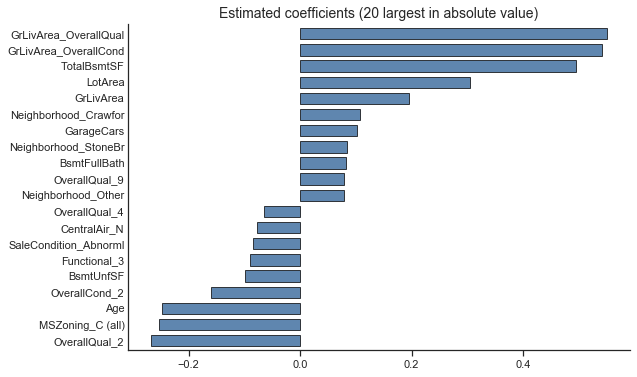

In [19]:
plot_coefficients(lasso, predictors)
plt.show()

### 7. Elastic Net

Finally, we also consider the elastic net method.

In [20]:
from sklearn.linear_model import ElasticNetCV

enet = ElasticNetCV(l1_ratio=[0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9, 0.99], cv=5)
enet.fit(X_train, y_train)

ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
       l1_ratio=[0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99],
       max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
       positive=False, precompute='auto', random_state=None,
       selection='cyclic', tol=0.0001, verbose=0)

In [21]:
enet.l1_ratio_

0.4

In [22]:
len(predictors)-np.sum(enet.coef_==0.0)

132

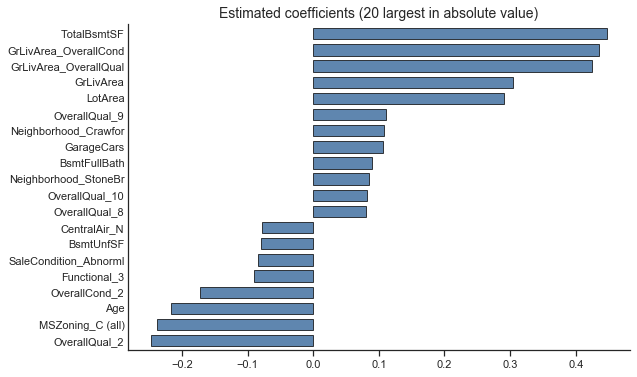

In [23]:
plot_coefficients(enet, predictors)
plt.show()

### 8. Model Evaluation


In [24]:
ols = LinearRegression()
ols.fit(X_train, y_train)


columns=['Test RMSE', 'Test R2', 'Test MAE']
rows=['OLS','Forward', 'Lasso', 'Ridge', 'Elastic Net']
results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[ols, fwd, lasso, ridge, enet]

for i, method in enumerate(methods):
    
    y_pred  = method.predict(X_test)   
    results.iloc[i,0] = np.sqrt(mean_squared_error(y_test, y_pred))
    results.iloc[i,1] = r2_score(y_test, y_pred)
    results.iloc[i,2] = mean_absolute_error(y_test, y_pred)

results.round(3)

,Test RMSE,Test R2,Test MAE
OLS,0.118,0.917,0.077
Forward,0.118,0.917,0.079
Lasso,0.112,0.926,0.076
Ridge,0.112,0.925,0.075
Elastic Net,0.111,0.927,0.075


### 9. Pipeline (note)

As an additional detail that is useful to know,  a Scikit-Learn [pipeline](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline) allows you to combine data pre-processing with a final estimator. Here's an example. 

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

alphas = list(np.logspace(-15, 15, 31, base=2))
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('estimator', RidgeCV(alphas=alphas)),
])

ridge_pipeline.fit(train[predictors], y_train)
y_pred = ridge_pipeline.predict(test[predictors])
print(y_pred[0]) 

12.304466710026587


### Formatting

The two cells below format the notebook for display online. Please omit them from your work.

In [26]:
%%html
<style>
@import url('https://fonts.googleapis.com/css?family=Source+Sans+Pro|Open+Sans:800&display=swap');
</style>

In [27]:
from IPython.core.display import HTML
style = open('css\jupyter.css', "r").read()
HTML('<style>'+ style +'</style>')